In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os, sys, shutil
sys.path.append("..")
import pandas as pd

from lammpsrun import *
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule, bcc110, bcc111
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
ephemeral = r"/rds/general/user/yx6015/ephemeral/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
print(cx1_out + '\n' + sim_path)
potential = "fe_o_water_fe_o_c_full_water.reax"

/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


# Equilibrating Ferrite

In [2]:
ferrite = crystal(symbols = ['Fe'],
                  basis = [[0, 0, 0]],
                  spacegroup=229,
                  cellpar=[2.870, 2.870, 2.870, 90, 90, 90],
                  primitive_cell=False)

In [3]:
ferrite_bulk = ferrite.repeat((4, 4, 4))
ferrite_bulk.get_cell_lengths_and_angles()
ferrite_dir = os.path.join(sim_path, 'ferrite')

In [4]:
ferrite_bulk_calc = reaxff_params_generator(ferrite_bulk, 'ferrite_300K', write_input=True,
                                            input_fd=ferrite_dir,
                                            #min_modify="line quadratic",
                                            run=20000,
                                            timestep=0.1,
                                            fix=["fix_npt all npt temp 300.0 300.0 100.0 aniso 1.0 1.0 100.0",
                                                 "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c"],
                                            velocity=["all create 300.0 1050027 rot yes mom yes dist gaussian"],
                                            potential=potential)

Make manual edits to input file here.

In [53]:
ferrite_bulk_PBS = PBS_Submitter(job_names="ferrite_300K",
                                 job_commands="mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 4 -in ferrite_300K.lammpsin -screen none\n",
                                 modules=["mpi", "lammps/11Aug17", "intel-suite/2017"],
                                 walltime="24:00:00",
                                 proc_nodes=1,
                                 proc_cpus=8,
                                 proc_mpiprocs=2,
                                 proc_threads=4,
                                 memory=32,
                                 source_files=['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                                               '$PBS_O_WORKDIR/ferrite_300k.lammps*'])

In [54]:
os.chdir(ferrite_dir)
ferrite_out, ferrite_err = ferrite_bulk_PBS.run()
os.chdir(sim_path)
print(ferrite_out)

['2447047.cx1']


In [103]:
qstat_monitor()

           JobID        Job Name            User         Runtime          Status           Queue
     2408871.cx1    ferrite_300K          yx6015        01:26:32            Done v1_throughput24


In [55]:
# Move all the log and error files over

for outfile, job_out in zip(["ferrite_300K"], ferrite_out):
    shutil.move(os.path.join(sim_path, "ferrite", outfile + ".err"), os.path.join(ephemeral, job_out))
    shutil.move(os.path.join(sim_path, "ferrite", outfile + ".log"), os.path.join(ephemeral, job_out))

## Reading final ferrite configuration

In [58]:
ferrite_out_dir

'/rds/general/user/yx6015/ephemeral/2447047.cx1'

In [60]:
ferrite_out_dir = os.path.join(ephemeral, ferrite_out[0])
ferrite_bulk_calc.read_lammps_log(lammps_log=os.path.join(ferrite_out_dir, "log.lammps"))
# Converting lammpstrj to ase traj
ferrite_bulk_calc.trajectory_out = Trajectory(os.path.join(ferrite_out_dir, "ferrite_300K.traj"), 'w')
ferrite_bulk_calc.read_lammps_trj(lammps_trj=os.path.join(ferrite_out_dir, "ferrite_300K.lammpstrj"))
ferrite_bulk_calc.trajectory_out.close()
ferrite_bulk_traj = Trajectory(os.path.join(ferrite_out_dir, "ferrite_300K.traj"), 'r')

In [61]:
ferrite_bulk_df = pd.DataFrame(ferrite_bulk_calc.thermo_content)

In [62]:
ferrite_bulk_df.step = ferrite_bulk_df.step.astype(int)
ferrite_bulk_df = ferrite_bulk_df.set_index('step')
ferrite_bulk_df.head()

,atoms,cpu,etotal,ke,lx,ly,lz,pe,press,pxx,pxy,pxz,pyy,pyz,pzz,temp,vol
step,,,,,,,,,,,,,,,,,
0,128.0,0.000000,-12704.730,113.56886,11.480000,11.480000,11.480000,-12818.298,-28462.883,-28659.658,-195.94227,-20.736258,-28452.512,-146.17737,-28276.481,300.00000,1512.9538
1,128.0,0.023093,-12704.737,113.56784,11.479952,11.479953,11.479953,-12818.305,-28445.028,-28641.761,-195.93599,-20.735887,-28434.669,-146.17608,-28258.653,299.99729,1512.9351
2,128.0,0.047568,-12704.760,113.56475,11.479810,11.479811,11.479813,-12818.325,-28391.479,-28588.091,-195.91715,-20.734779,-28381.161,-146.17219,-28205.186,299.98915,1512.8792
3,128.0,0.069672,-12704.799,113.55961,11.479573,11.479576,11.479578,-12818.359,-28302.294,-28498.702,-195.88573,-20.732944,-28292.042,-146.16567,-28116.137,299.97556,1512.7860
4,128.0,0.094213,-12704.853,113.55240,11.479241,11.479246,11.479251,-12818.405,-28177.564,-28373.688,-195.84171,-20.730388,-28167.406,-146.15647,-27991.600,299.95653,1512.6557


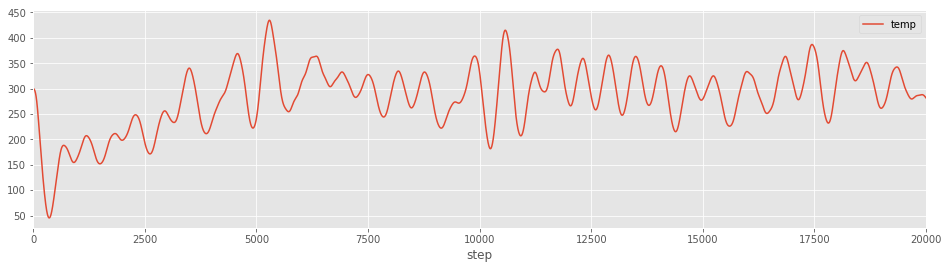

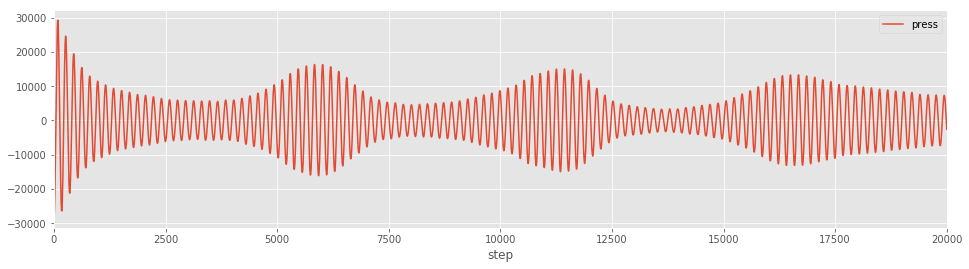

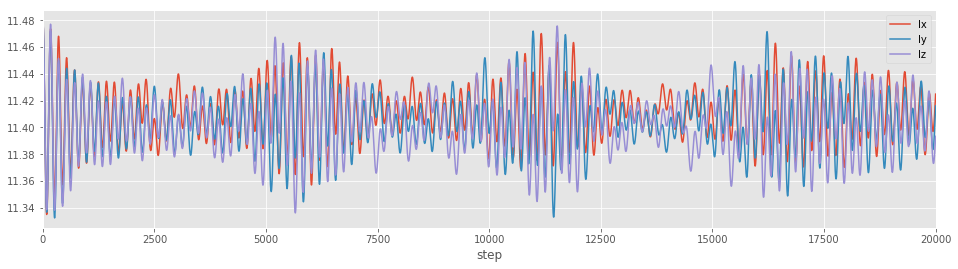

In [63]:
ferrite_bulk_df.plot(y=['temp'], figsize=(16, 4))
ferrite_bulk_df.plot(y=['press'], figsize=(16, 4))
ferrite_bulk_df.plot(y=['lx', 'ly', 'lz'], figsize=(16, 4))

plt.show()

In [64]:
print("Final average Lx is", np.mean(ferrite_bulk_df.lx[-5000:])/ferrite_bulk_df.lx[0])
print("Final average Ly is", np.mean(ferrite_bulk_df.ly[-5000:])/ferrite_bulk_df.ly[0])
print("Final average Lz is", np.mean(ferrite_bulk_df.lz[-5000:])/ferrite_bulk_df.lz[0])

Final average Lx is 0.9939879622299631
Final average Ly is 0.9935485200174217
Final average Lz is 0.9932086084843186


We take ferrite lattice constants as-is: 2.870

# Creating the Simulation Box

## Create the Iron Bits

In [2]:
aq_thickness = 100

In [3]:
Fe_bcc111_l32 = bcc111('Fe', a=2.870, size=(8,8,32), orthogonal=True, vacuum=1)
Fe_bcc111_l32.set_cell(Fe_bcc111_l32.get_cell() + np.array([[0,0,0],[0,0,0],[0,0,aq_thickness]]))

In [4]:
aq_cell_l100 = list(Fe_bcc111_l32.get_cell_lengths_and_angles()[:2]) + [aq_thickness]

H2O_l100 = create_water_region(aq_cell_l100)
H2O_l100.translate([0, 0, Fe_bcc111_l32.get_cell_lengths_and_angles()[2]-100])

Fe_bcc111_l32_aq_l100 = Fe_bcc111_l32 + H2O_l100
Fe_bcc111_l32_aq_l100.set_pbc([True, True, False])
Fe_bcc111_l32_aq_l100

Atoms(symbols='H5760Fe2048O2880', pbc=[True, True, False], cell=[32.470343392086264, 28.120142247150884, 127.6834267249005], tags=...)

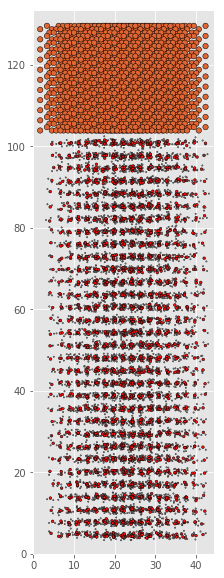

In [8]:
plt.figure(figsize=(18, 10))
plot_atoms(Fe_bcc111_l32_aq_l100, radii=0.5, rotation=('90x,45y,0z'))
#Fe_bcc111_l40_aq.write(sim_path + "fe_aq/Fe_bcc111_l40_aq.extxyz")
plt.show()

In [5]:
ferrite_aq_dir = os.path.join(sim_path, "ferrite_aq")
Fe_bcc111_l32_aq_l100_efields = np.arange(0.3, 0.7, 0.1) # V/A = 100MV/cm => 0 MV/cm to 45 MV/cm
Fe_bcc111_l32_aq_l100_efields_names = ['Fe_bcc111_l32_aq_l100_efield_{0:.0f}MVcm'.format(x*100) for x in Fe_bcc111_l32_aq_l100_efields]
Fe_bcc111_l32_aq_l100_efields_names

['Fe_bcc111_l32_aq_l100_efield_30MVcm',
 'Fe_bcc111_l32_aq_l100_efield_40MVcm',
 'Fe_bcc111_l32_aq_l100_efield_50MVcm',
 'Fe_bcc111_l32_aq_l100_efield_60MVcm']

In [6]:
for sim, efield in zip(Fe_bcc111_l32_aq_l100_efields_names, Fe_bcc111_l32_aq_l100_efields):
    calc = reaxff_params_generator(Fe_bcc111_l32_aq_l100, sim,
                                   write_input=True,
                                   input_fd=ferrite_aq_dir,
                                   run=500000,
                                   timestep=0.1,
                                   fix=["all_nvt all nvt temp 300.0 300.0 100.0",
                                        "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c",
                                        "elec all efield 0.0 0.0 {0:.2f}".format(efield),
                                        "reax_info all reax/c/bonds 10 bonds.tatb",
                                        "zwalls all wall/reflect zlo EDGE zhi EDGE",],
                                   velocity=["all create 300.0 1050027 rot yes mom yes dist gaussian"],
                                   potential=potential)

Make manual edits to input file here.

In [7]:
Fe_bcc111_l32_aq_l100_efields_input = ["{0}.lammpsin".format(x) for x in Fe_bcc111_l32_aq_l100_efields_names]
Fe_bcc111_l32_aq_l100_efields_commands = ["mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 8 -in {0} -screen none\n".format(x) for x in Fe_bcc111_l32_aq_l100_efields_input]
Fe_bcc111_l32_aq_l100_efields_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                                               '$PBS_O_WORKDIR/'+x+".*"] for x in Fe_bcc111_l32_aq_l100_efields_names]

Fe_bcc111_l32_aq_l100_efields_PBS = PBS_Submitter(job_names=Fe_bcc111_l32_aq_l100_efields_names,
                                                  job_commands=Fe_bcc111_l32_aq_l100_efields_commands,
                                                  modules=["mpi", "lammps/11Aug17", "intel-suite/2017"],
                                                  walltime="24:00:00",
                                                  proc_nodes=1,
                                                  proc_cpus=48, #mpiprocs x threads = cpus
                                                  proc_mpiprocs=6, 
                                                  proc_threads=8,
                                                  memory=48,
                                                  source_files=Fe_bcc111_l32_aq_l100_efields_source_files)

In [8]:
Fe_bcc111_l32_aq_l100_efields_PBS.params

{'source_files': [['$HOME/LAMMPS_Simulation/potentials/fe_o_water_fe_o_c_full_water.reax',
   '$PBS_O_WORKDIR/Fe_bcc111_l32_aq_l100_efield_30MVcm.*'],
  ['$HOME/LAMMPS_Simulation/potentials/fe_o_water_fe_o_c_full_water.reax',
   '$PBS_O_WORKDIR/Fe_bcc111_l32_aq_l100_efield_40MVcm.*'],
  ['$HOME/LAMMPS_Simulation/potentials/fe_o_water_fe_o_c_full_water.reax',
   '$PBS_O_WORKDIR/Fe_bcc111_l32_aq_l100_efield_50MVcm.*'],
  ['$HOME/LAMMPS_Simulation/potentials/fe_o_water_fe_o_c_full_water.reax',
   '$PBS_O_WORKDIR/Fe_bcc111_l32_aq_l100_efield_60MVcm.*']],
 'job_names': ['Fe_bcc111_l32_aq_l100_efield_30MVcm',
  'Fe_bcc111_l32_aq_l100_efield_40MVcm',
  'Fe_bcc111_l32_aq_l100_efield_50MVcm',
  'Fe_bcc111_l32_aq_l100_efield_60MVcm'],
 'job_commands': [['mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 8 -in Fe_bcc111_l32_aq_l100_efield_30MVcm.lammpsin -screen none\n',
   'mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 8 -in Fe_bcc111_l32_aq_l100_efield_40MVcm.lammpsin -screen none\n',
   'mpiexec

In [10]:
os.chdir(ferrite_aq_dir)

Fe_bcc111_l32_aq_l100_efields_out, Fe_bcc111_l32_aq_l100_efields_err = Fe_bcc111_l32_aq_l100_efields_PBS.run()

os.chdir(sim_path)
print(Fe_bcc111_l32_aq_l100_efields_out, Fe_bcc111_l32_aq_l100_efields_names)

['2460627.cx1', '2460628.cx1', '2460629.cx1'] ['Fe_bcc111_l32_aq_l100_efield_40MVcm', 'Fe_bcc111_l32_aq_l100_efield_50MVcm', 'Fe_bcc111_l32_aq_l100_efield_60MVcm']


In [11]:
qstat_monitor()

AttributeError: 'list' object has no attribute 'decode'

In [87]:
# Move all the log and error files over

for outfile, job_out in zip(Fe_bcc111_l32_aq_l100_efields_names, Fe_bcc111_l32_aq_l100_efields_out):
    shutil.move(os.path.join(ferrite_aq_dir, outfile + ".err"), os.path.join(ephemeral, job_out))
    shutil.move(os.path.join(ferrite_aq_dir, outfile + ".log"), os.path.join(ephemeral, job_out))

In [88]:
out_dir = [os.path.join(ephemeral, x) for x in Fe_bcc111_l32_aq_l100_efields_out]
convert_scripts_dir = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Scripts/"
convert_commands = ["python convert_script.py {}".format(x) for x in Fe_bcc111_l32_aq_l100_efields_names]
convert_names = [x+"_convert" for x in Fe_bcc111_l32_aq_l100_efields_names]
convert_source_files = [[os.path.join(x, "*lammpstrj"),
                         os.path.join(x, "*extxyz"), 
                         os.path.join(convert_scripts_dir, "convert_script.py"),
                         os.path.join(convert_scripts_dir, "lammpsrun.py")] for x in out_dir]

convert_PBS = PBS_Submitter(job_names=convert_names,
                            job_commands=convert_commands,
                            modules=["mpi", "anaconda3/personal"],
                            walltime="72:00:00",
                            proc_nodes=1,
                            proc_cpus=8,
                            proc_mpiprocs=8, 
                            memory=32,
                            source_files=convert_source_files)

In [91]:
os.chdir(ferrite_aq_dir)

convert_out, convert_err = convert_PBS.run()

os.chdir(sim_path)
print(convert_out)

['2460484.cx1']
